# Libraries

In [1]:
import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
# from keras.callbacks import ReduceLROnPlateau
from time import perf_counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras import applications
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras

In [2]:
import tensorflow as tf

print(tf.__version__)

2.10.0


# Check GPU device

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1749468586561496819
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6243221504
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3296241068016414671
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6242172928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7293458718950819372
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5"
 xla_global_id: 2144165316]

# Data Load

In [7]:
image_directory = 'D:/19기 인턴 multi-label 데이터셋/Data_folder/'

#Now let us read metadata to get our Y values (multiple lables)

df = pd.read_csv('D:/crack_final.csv')
   
print(df.head())     # printing first five rows of the file
print(df.columns)
print(df.shape)

           ID  101  102  103  104
0  train_img1    1    0    0    0
1  train_img3    1    1    1    0
2  train_img4    1    1    0    0
3  train_img5    0    1    0    0
4  train_img6    1    0    0    0
Index(['ID', '101', '102', '103', '104'], dtype='object')
(26952, 5)


In [9]:
X_dataset= []  

for i in tqdm(range(df.shape[0])):
    img = image.load_img(image_directory +df['ID'][i]+'.jpg', target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)
    
X = np.array(X_dataset)

#Id and Genre are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
y = np.array(df.drop(['ID'], axis=1))

100%|████████████████████████████████████████████████████████████████████████████| 26952/26952 [46:45<00:00,  9.61it/s]


# HyperParameters

In [10]:
Batch_size = 8

cos_decay_wr = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=0.0001,first_decay_steps=10,
    t_mul=2.0,m_mul=0.7,alpha=0.0,name=None)

# SGDWR = tfa.optimizers.SGDW(weight_decay = 0.0001,
#    momentum = 0.9, nesterov = False)

SGDR = tf.keras.optimizers.SGD(momentum=0.9)

# AdamWR = tfa.optimizers.AdamW(
#     weight_decay=0.005, beta_1=0.9, beta_2=0.999)

AdamR = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-07)

Epochs = 30


Random_state = 42

tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=True,
    name='binary_focal_crossentropy'
)

# Train test split

In [11]:
X_train, x_test, Y_train, y_test = train_test_split(X, y, random_state = Random_state, test_size = 0.2)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, random_state = Random_state, test_size = 0.125)

# Data Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        shear_range=0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
)

In [14]:
datagen.fit(x_train)
train_datagen = datagen.flow(x_train, y_train, batch_size=Batch_size)

# Modeling

In [15]:
base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 14, 14, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block33_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 14, 14, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)                           )                                 'conv4_block33_2_conv[0][0]']   
          

                                                                                                  
 conv4_block37_concat (Concaten  (None, 14, 14, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 14, 14, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 14, 14, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_blo

 conv4_block42_0_relu (Activati  (None, 14, 14, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 14, 14, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block46_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 14, 14, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 14, 14, 1728  6912       ['conv4_block46_concat[0][0]']   
 lization)

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 7, 7, 960)   0           ['conv5_block1_concat[0][0]',    
 te)      

 conv5_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 7, 7, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 7, 7, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 7, 7, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block11_0_relu (Activati  (None, 7, 7, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 7, 7, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 7, 7, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block19_concat (Concaten  (None, 7, 7, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 7, 7, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 7, 7, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 7, 7, 128)    192512      ['conv5_block20_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 7, 7, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block28_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 7, 7, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 7, 7, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 bn (BatchNormalization)        (None, 7, 7, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 7, 7, 1920)   0           ['bn[0][0]']                     
                                                                                                  
Total params: 18,321,984
Trainable params: 18,092,928
Non-trainable params: 229,056
__________________________________________________________________________________________________


In [16]:
for layer in base_model.layers:
    layer.trainable = True

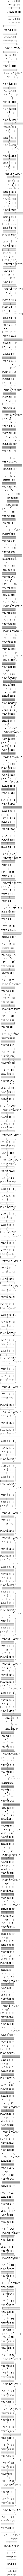

In [22]:
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
predictions = Dense(4, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs = predictions)

from tensorflow.keras.utils import plot_model
%matplotlib inline
plot_model(model, show_shapes=True)

## Model log file save to h5

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelcheckpoint = ModelCheckpoint('DenseNet201_01_06_imagenet_final.h5', monitor='val_loss', mode='min', save_best_only=True)
# 파일명 저장 :  모델명_날짜_가중치사용여부.h5

In [24]:
class lrHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.lr = []
        
    def on_epoch_begin(self, epoch, logs):
        self.lr.append(tf.keras.backend.get_value(self.model.optimizer.lr))

lrhistory = lrHistory()

In [25]:
lr_scheduler = LearningRateScheduler(cos_decay_wr, verbose=1)

In [26]:
import gc
gc.collect()

204587

In [27]:
model.compile(optimizer=AdamR,loss='binary_crossentropy', metrics=['accuracy'])
history1 = model.fit(train_datagen, validation_data=(x_val,y_val),epochs=Epochs,callbacks=[lr_scheduler,modelcheckpoint])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/30
2359/2359 [==============================] - 574s 225ms/step - loss: 0.4388 - accuracy: 0.4310 - val_loss: 0.3663 - val_accuracy: 0.4952 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.75528237177059e-05.
Epoch 2/30
2359/2359 [==============================] - 527s 223ms/step - loss: 0.3692 - accuracy: 0.5065 - val_loss: 0.3645 - val_accuracy: 0.5586 - lr: 9.7553e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.045084152603522e-05.
Epoch 3/30
2359/2359 [==============================] - 531s 225ms/step - loss: 0.3488 - accuracy: 0.5121 - val_loss: 0.3209 - val_accuracy: 0.5352 - lr: 9.0451e-05

Epoch 4: LearningRateScheduler setting learning rate to 7.938926137285307e-05.
Epoch 4/30
2359/2359 [==============================] - 525s 223ms/step - loss: 0.3364 - accuracy: 0.5084 - val_loss: 0.3030 - val_accuracy: 0.5727 - lr: 7.9389e-05

Epoch 5: LearningRat

##  Loss & Accuracy log save to csv 

In [28]:
pd.DataFrame.from_dict(history1.history).to_csv('DenseNet201_01_06_imagenet_f.csv',index=False)
# 파일명 :  모델명_날짜_가중치사용여부.csv

# Evaluation

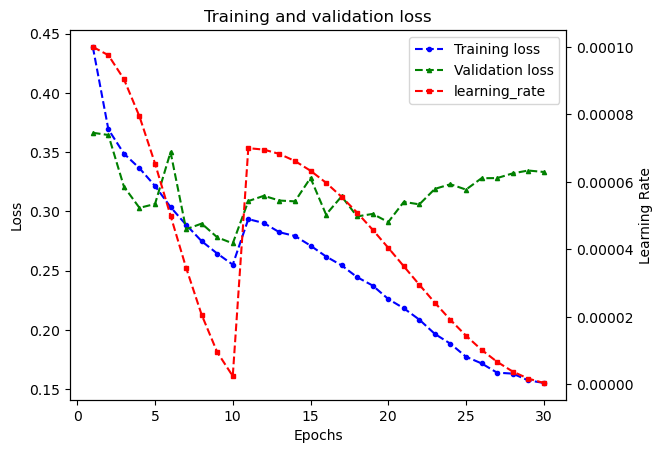

In [29]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
epochs = range(1, Epochs + 1)
loss = history1.history['loss']
val_loss = history1.history['val_loss']
lr = history1.history['lr']

line1 = ax1.plot(epochs, loss, color='b', linestyle='--', marker='o', label = 'Training loss',markersize=3)
line2 = ax1.plot(epochs, val_loss, color='g', linestyle='--', marker='^', label='Validation loss',markersize=3)
line3 = ax2.plot(epochs, lr, color = 'r', linestyle='--', marker='s', label = 'learning_rate',markersize=3)

#plt.plot(epochs, loss, 'y', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
#plt.plot(epochs,lr, 'b', label='Learning_rate')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Learning Rate')

plt.legend(bbox_to_anchor=(1,1))

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc=1)
plt.show()

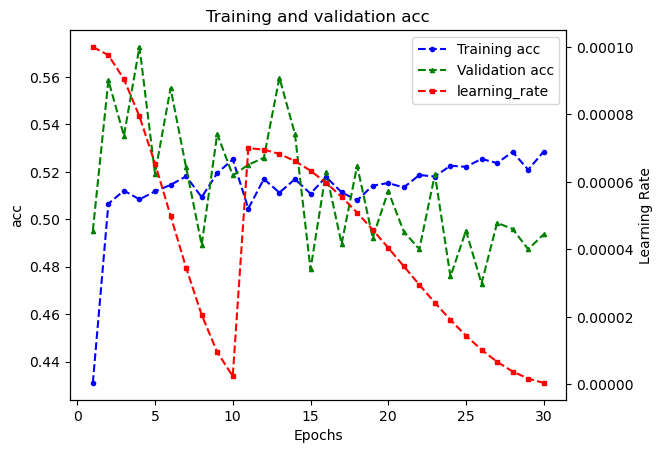

In [30]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

line1 = ax1.plot(epochs, acc, color='b', linestyle='--', marker='o', label = 'Training acc', markersize=3)
line2 = ax1.plot(epochs, val_acc, color='g', linestyle='--', marker='^', label='Validation acc', markersize=3)
line3 = ax2.plot(epochs, lr, color = 'r', linestyle='--', marker='s', label = 'learning_rate' , markersize=3)

ax1.set_title('Training and validation acc')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('acc')
ax2.set_ylabel('Learning Rate')
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc=1)
plt.show()

In [31]:
gc.collect()

6597

# Prediction

### best_model(10epochs, val_loss가 젤 작음) > model (30epochs)

In [40]:
best_model = tf.keras.models.load_model('DenseNet201_01_06_imagenet_final.h5')

In [32]:
with tf.device('device:GPU:1'):
    y_pred = model.predict(x_test)

169/169 [==============================] - 61s 306ms/step


In [42]:
gc.collect()

3565

In [43]:
with tf.device('device:GPU:1'):
    y_pred2 = best_model.predict(x_test)

169/169 [==============================] - 50s 271ms/step


In [ ]:
import gc
gc.collect()

In [ ]:
print("Actual \n", y_test)
print("\nPredicted \n",y_pred)

In [53]:
import numpy as np
from sklearn.preprocessing import Binarizer
from sklearn.metrics import classification_report

thresholds_1 = [0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,]
thresholds_2 = [0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61]
def get_eval_by_threshold(y_test, y_pred2, thresholds):
  # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
  for custom_threshold in thresholds_1:
    binarizer = Binarizer(threshold=custom_threshold).fit(y_pred2)
    custom_predict = binarizer.transform(y_pred2)
    print("\n임곗값 :", custom_threshold)
    print(classification_report(y_test, custom_predict,digits=3))

get_eval_by_threshold(y_test, y_pred2, thresholds_1)


임곗값 : 0.41
              precision    recall  f1-score   support

           0      0.673     0.896     0.769      2430
           1      0.943     0.974     0.958      4832
           2      0.845     0.922     0.882      2564
           3      0.895     0.931     0.913      1959

   micro avg      0.848     0.939     0.891     11785
   macro avg      0.839     0.931     0.880     11785
weighted avg      0.858     0.939     0.895     11785
 samples avg      0.856     0.935     0.875     11785


임곗값 : 0.42
              precision    recall  f1-score   support

           0      0.676     0.894     0.770      2430
           1      0.944     0.973     0.958      4832
           2      0.847     0.918     0.881      2564
           3      0.895     0.929     0.912      1959

   micro avg      0.849     0.937     0.891     11785
   macro avg      0.841     0.929     0.880     11785
weighted avg      0.860     0.937     0.895     11785
 samples avg      0.858     0.933     0.875     11785

C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-p

In [51]:
threshold = 0.57
y_new_pred2=[]
for sample in  y_pred2:
    y_new_pred2.append([1 if i>=threshold else 0 for i in sample ])
y_new_pred2 = np.array(y_new_pred2)
y_new_pred2

array([[1, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 1, 0, 0],
       ...,
       [1, 1, 0, 1],
       [1, 1, 0, 1],
       [0, 1, 1, 0]])

In [52]:
from sklearn.metrics import classification_report

label_names = ['101', '102', '103', '104']

print(classification_report(y_test, y_new_pred2,target_names=label_names,digits=3))

              precision    recall  f1-score   support

         101      0.744     0.848     0.792      2430
         102      0.954     0.956     0.955      4832
         103      0.887     0.883     0.885      2564
         104      0.912     0.904     0.908      1959

   micro avg      0.885     0.909     0.897     11785
   macro avg      0.874     0.898     0.885     11785
weighted avg      0.889     0.909     0.899     11785
 samples avg      0.887     0.907     0.879     11785



C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Show Wrong Image 

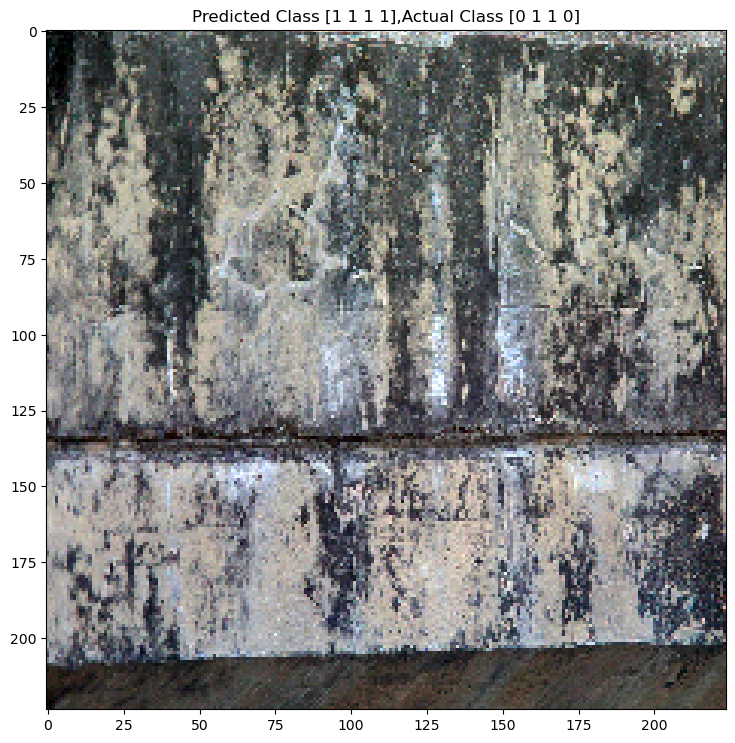

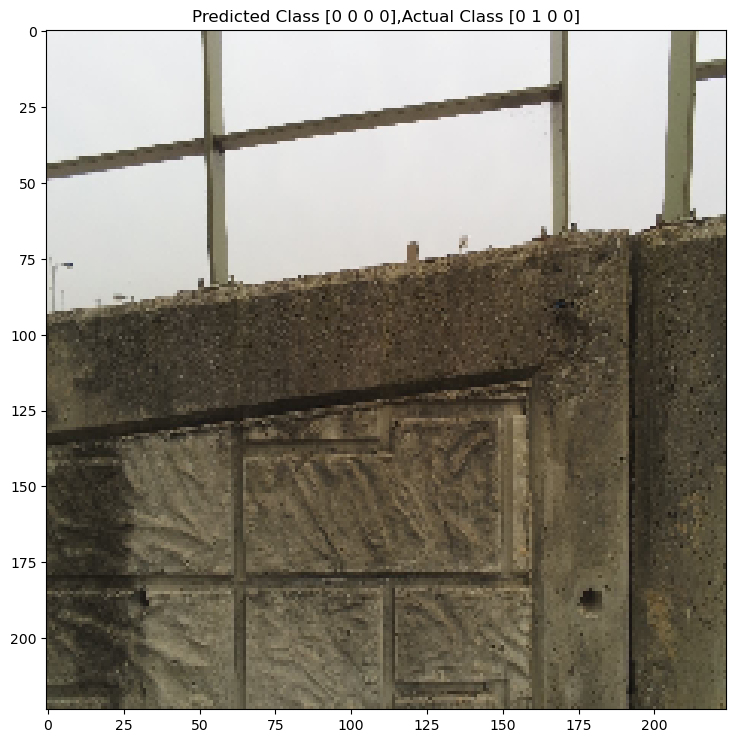

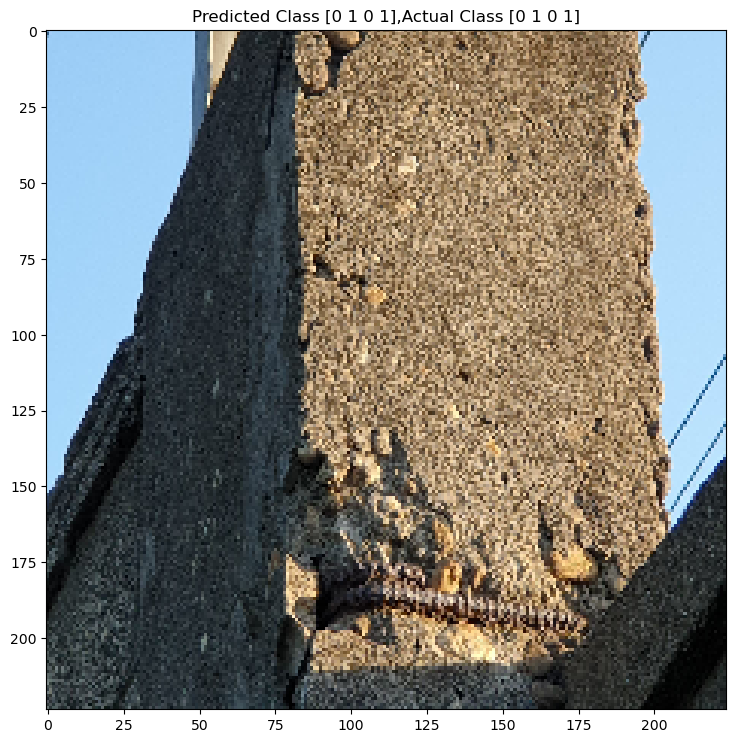

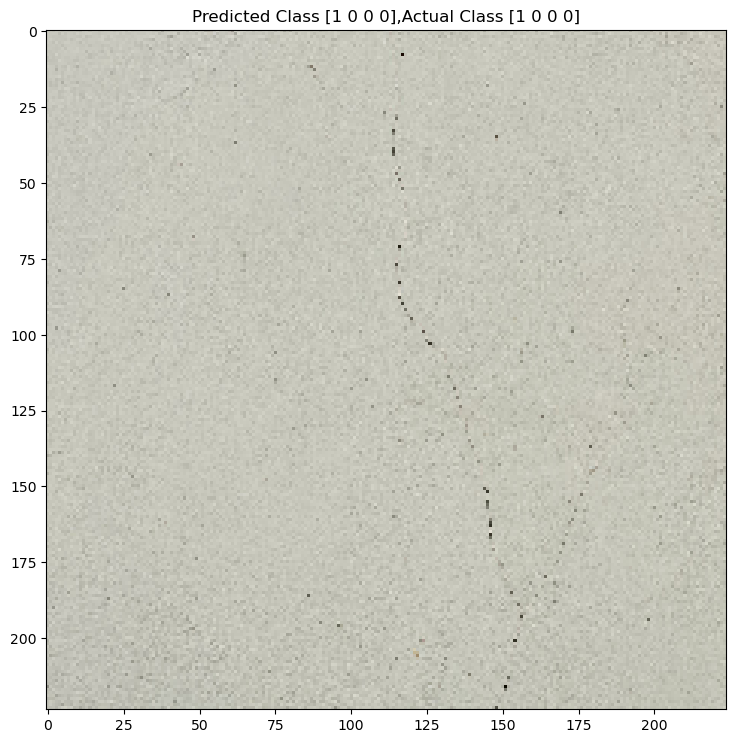

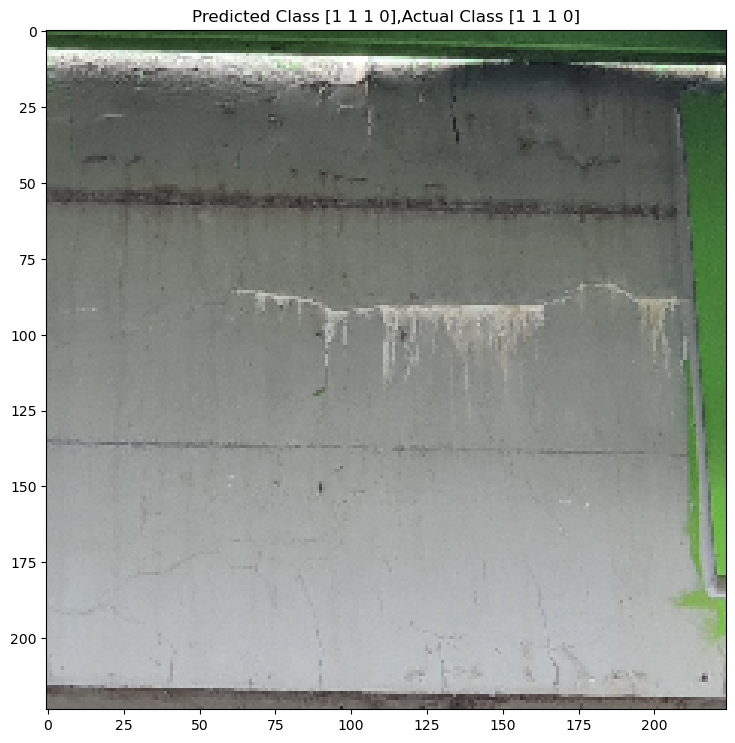

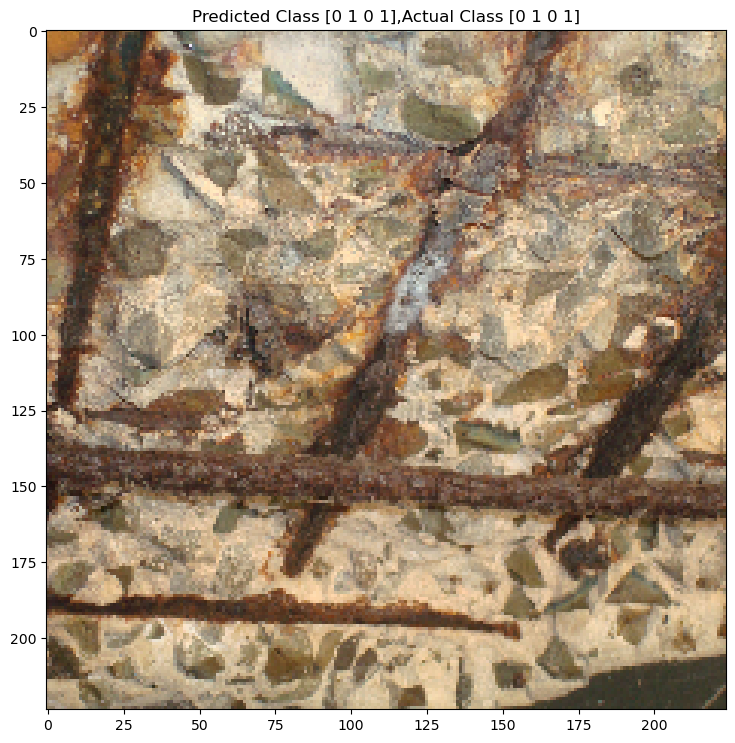

In [54]:
c = 150
for i in range(6):
    plt.figure(figsize=(20,30))
    plt.subplot(3,2, i+1)
    plt.imshow(x_test[c])
    plt.title("Predicted Class {},Actual Class {}".format(y_new_pred[c], y_test[c]))
    c += 1

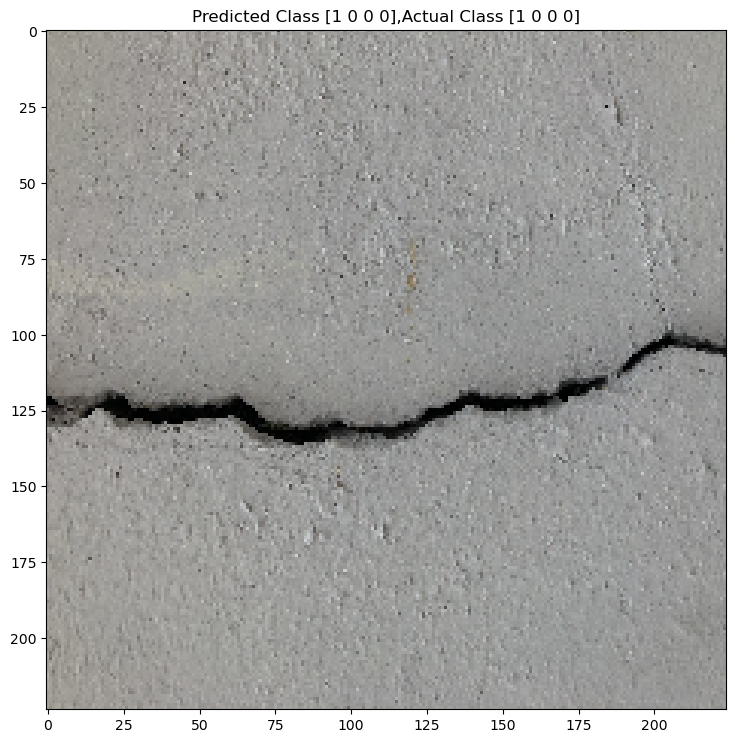

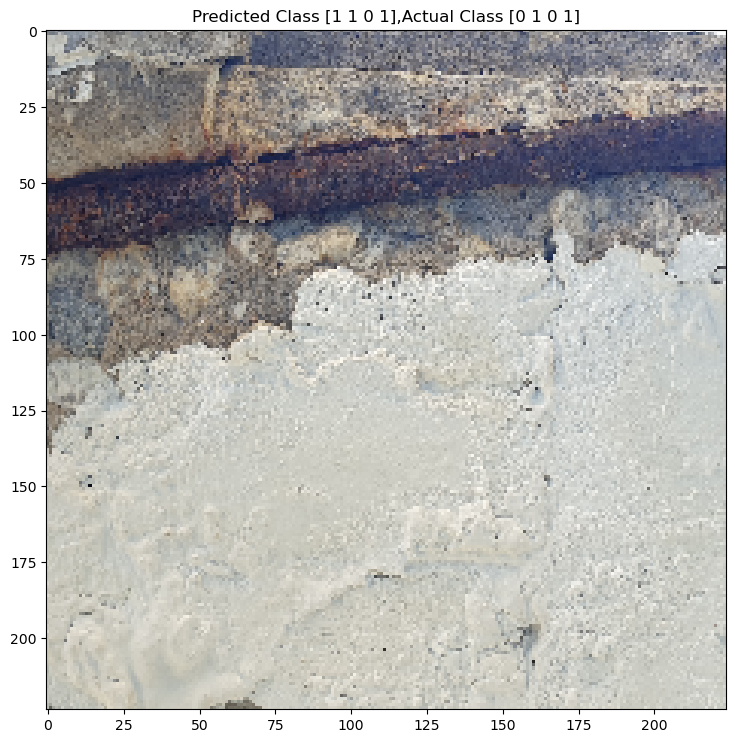

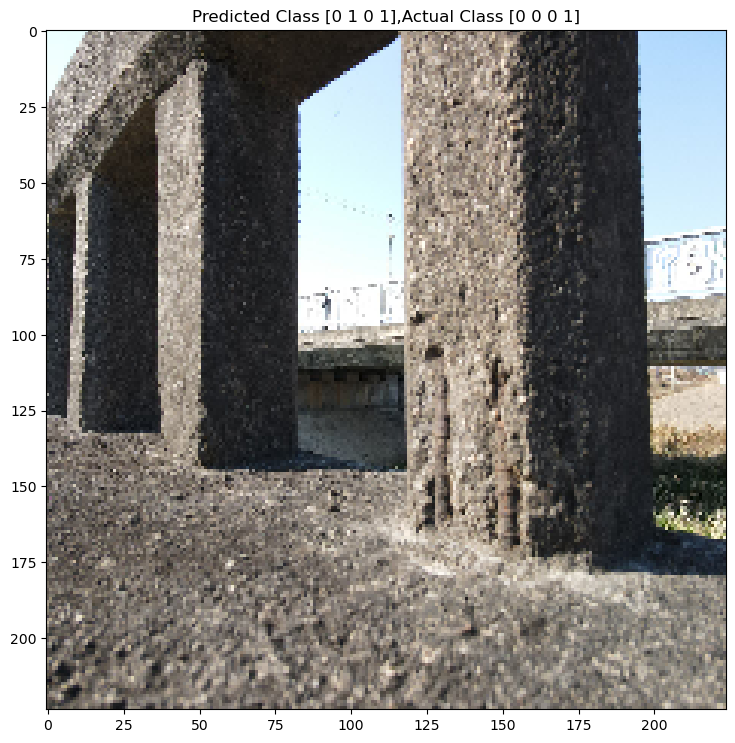

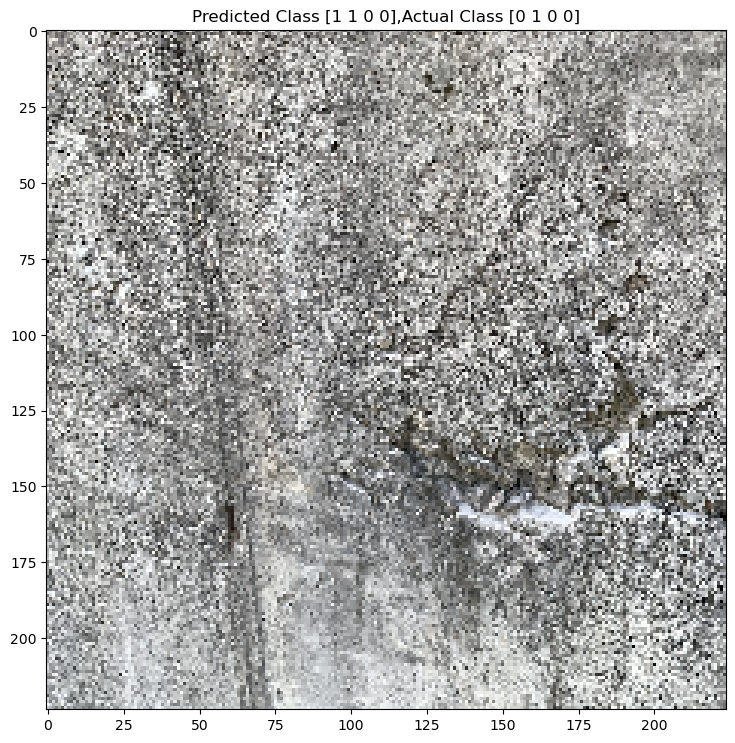

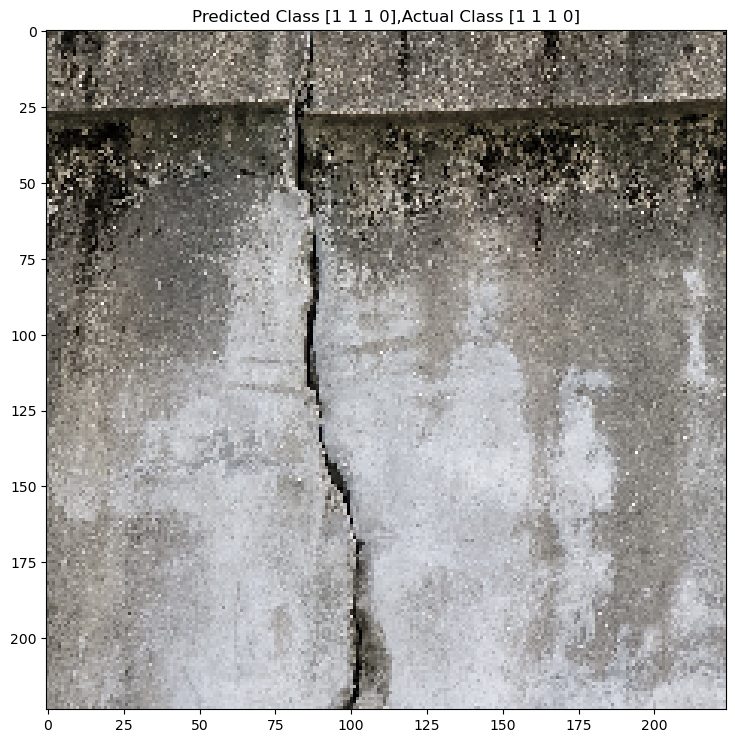

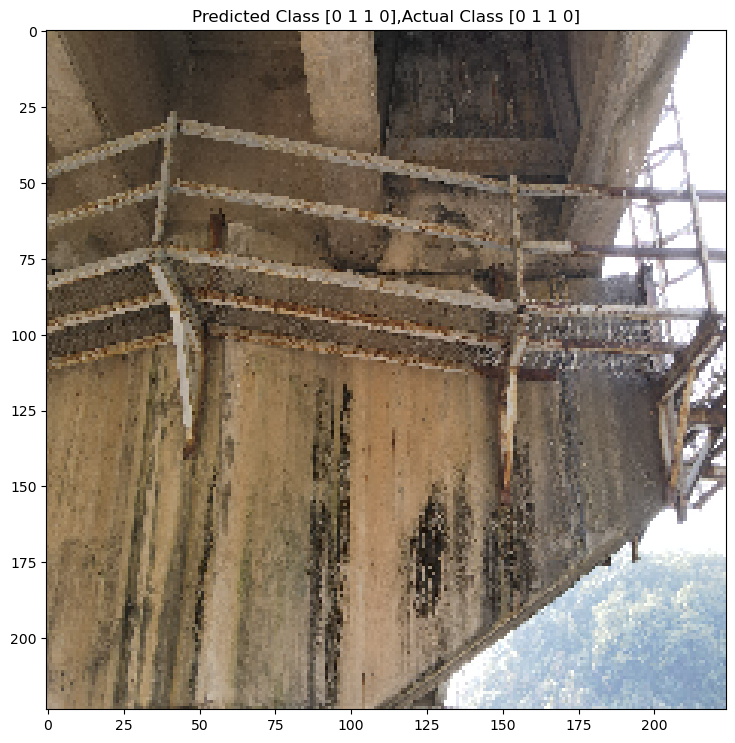

In [55]:
c = 350
for i in range(6):
    plt.figure(figsize=(20,30))
    plt.subplot(3,2, i+1)
    plt.imshow(x_test[c])
    plt.title("Predicted Class {},Actual Class {}".format(y_new_pred[c], y_test[c]))
    c += 1

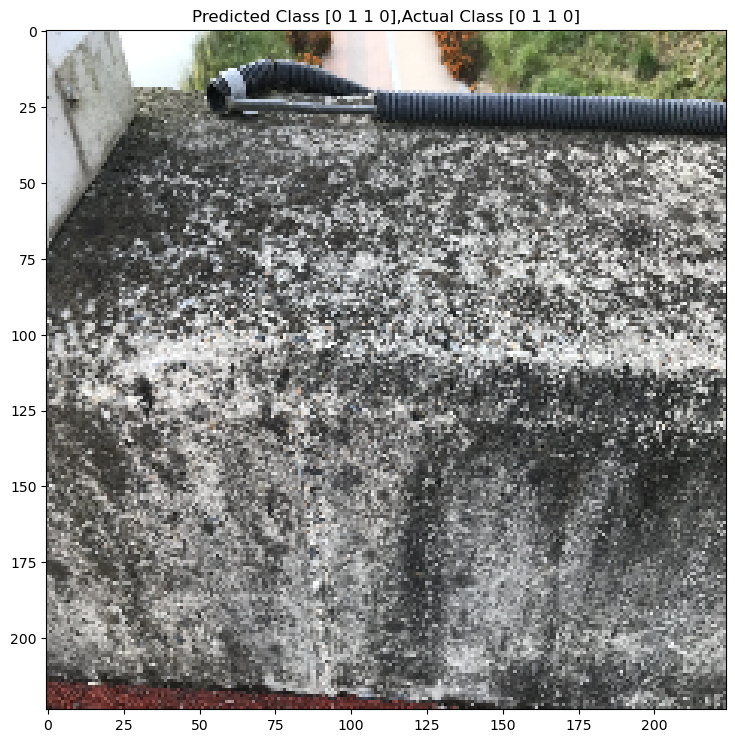

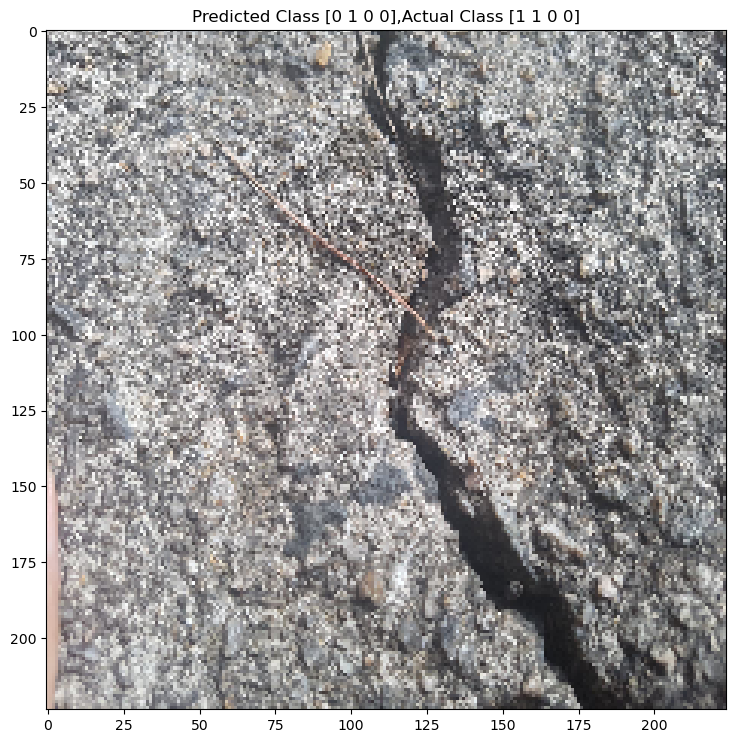

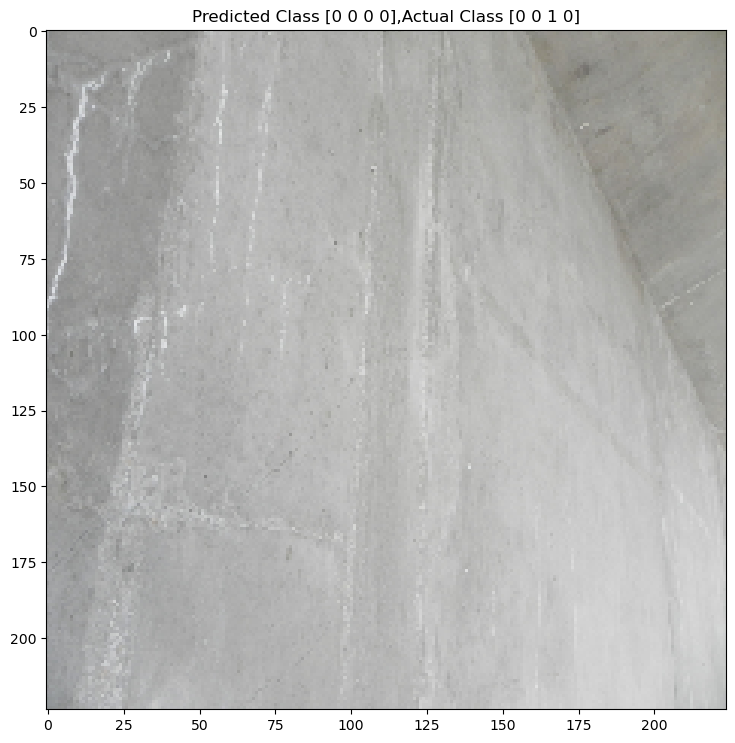

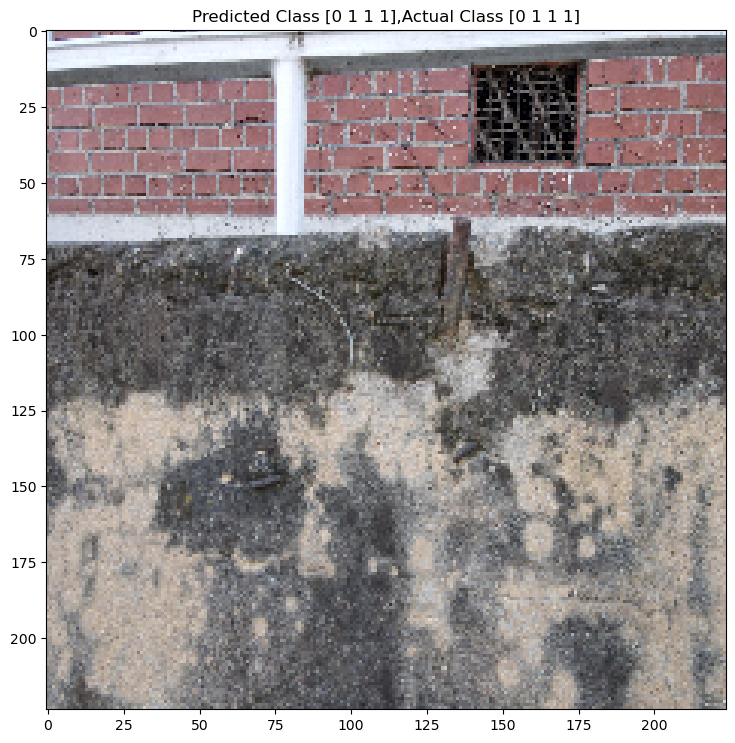

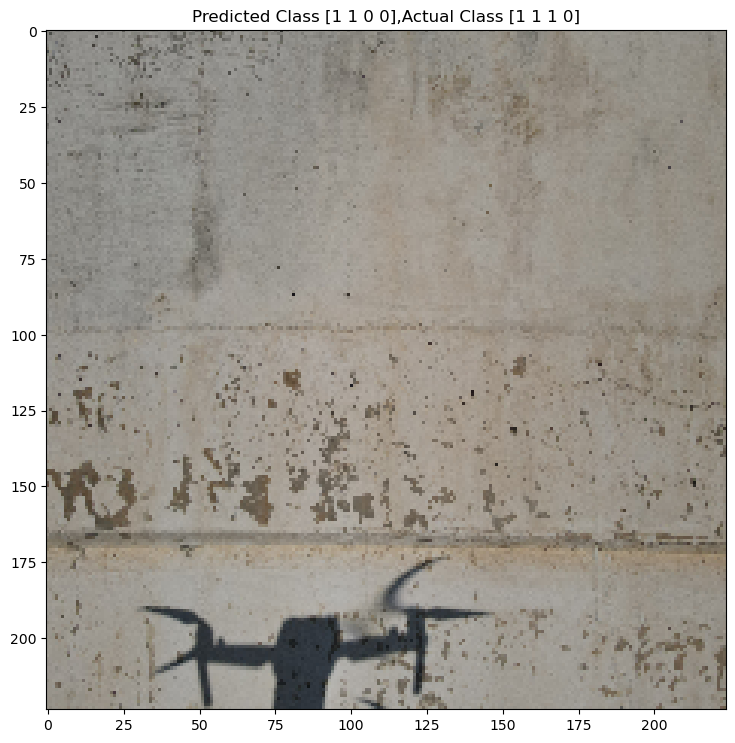

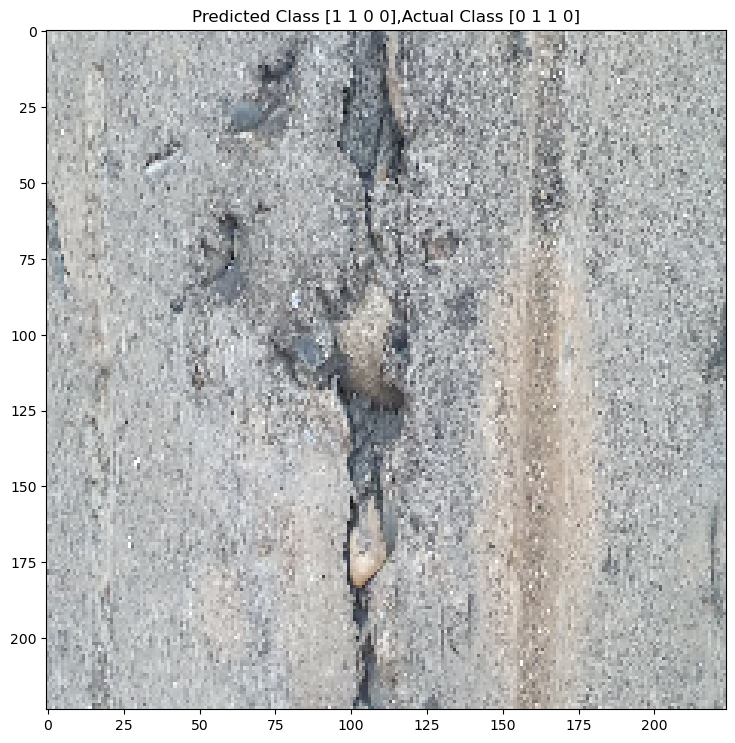

In [56]:
c = 550
for i in range(6):
    plt.figure(figsize=(20,30))
    plt.subplot(3,2, i+1)
    plt.imshow(x_test[c])
    plt.title("Predicted Class {},Actual Class {}".format(y_new_pred[c], y_test[c]))
    c += 1

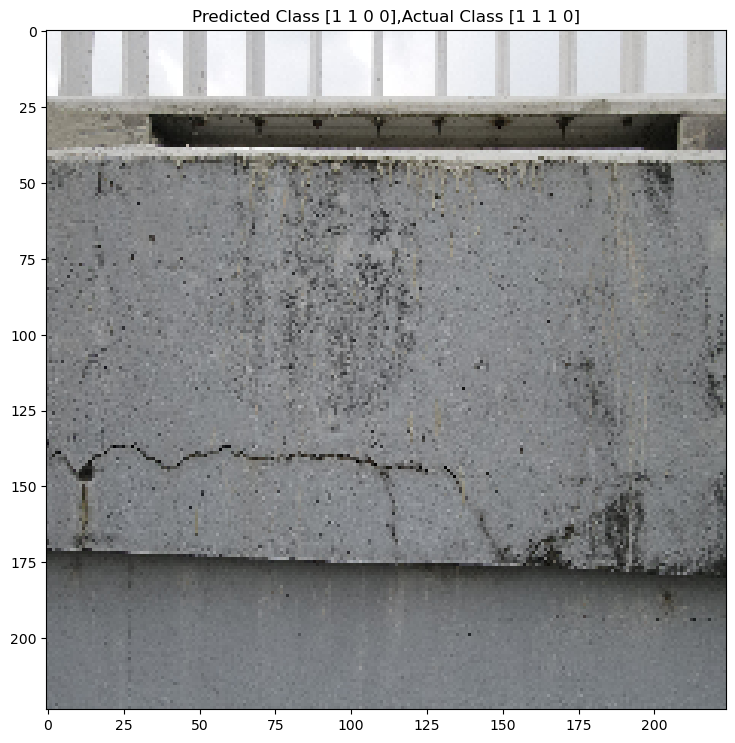

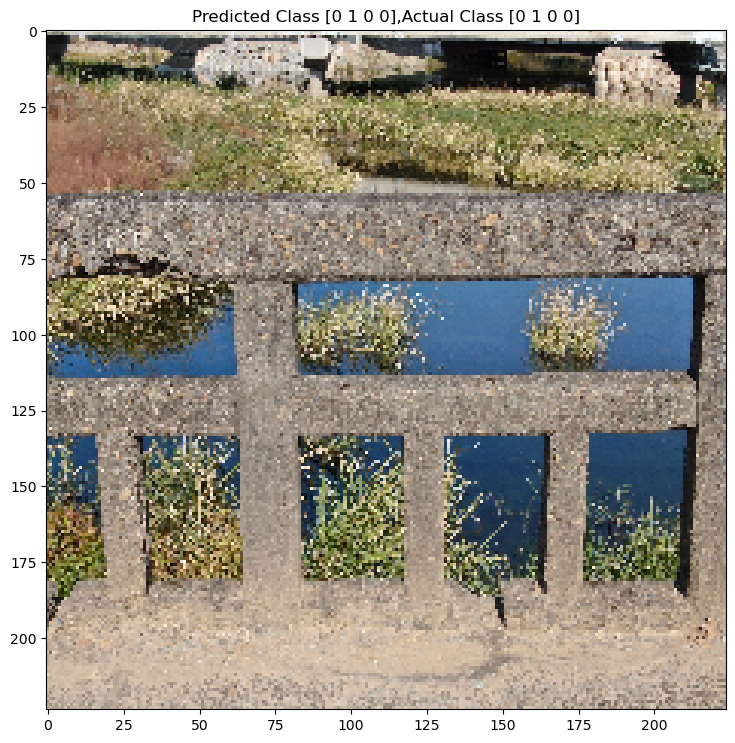

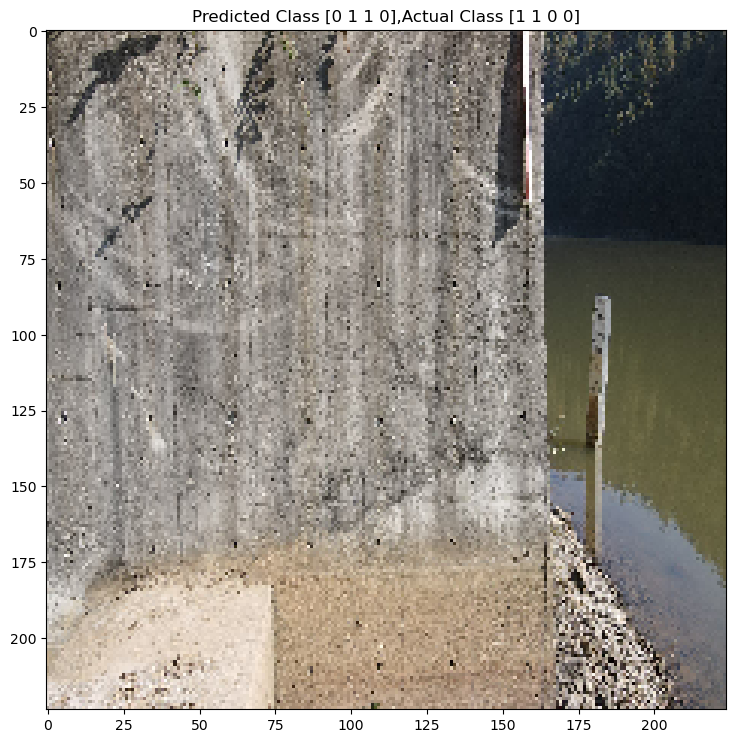

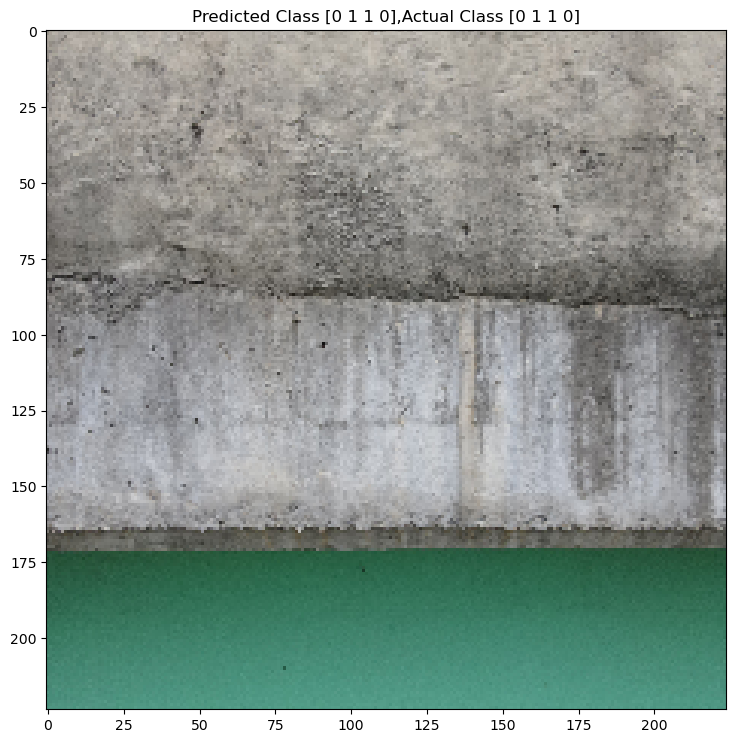

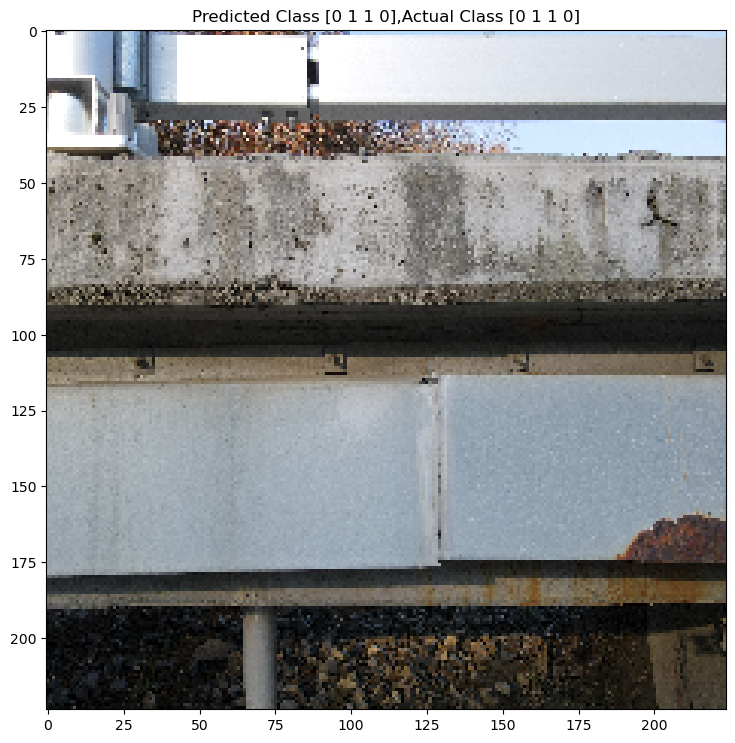

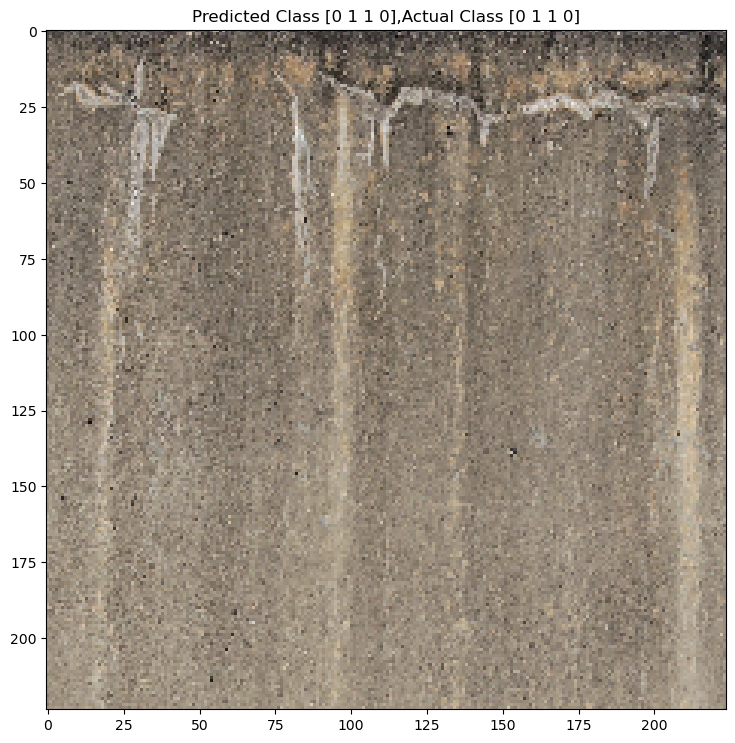

In [57]:
c = 750
for i in range(6):
    plt.figure(figsize=(20,30))
    plt.subplot(3,2, i+1)
    plt.imshow(x_test[c])
    plt.title("Predicted Class {},Actual Class {}".format(y_new_pred[c], y_test[c]))
    c += 1